# 1. Import Required Packages

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")
device

device(type='mps')

# 2. Dataset Preparation and Visualization

In [3]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

train_transform = transforms.Compose([
  transforms.RandomCrop(32, padding=4),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean, std, inplace=True)
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean, std, inplace=True)
])

In [4]:
train_dataset = datasets.CIFAR10(root="data",
                                 download=True,
                                 train=True,
                                 transform=train_transform)

test_dataset = datasets.CIFAR10(root="data",
                                download=True,
                                train=False,
                                transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
def denormalize(img):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

def plot_random_samples(dataset, n_rows=4, n_cols=4):
  n_samples = n_rows * n_cols
  sample_indices = np.random.choice(len(dataset), n_samples)

  imgs, labels = zip(*[dataset[i] for i in sample_indices])

  plt.figure(figsize=(8, 8))

  for i in range(n_samples):
    img = denormalize(imgs[i])

    plt.subplot(n_rows, n_cols, i + 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.title(dataset.classes[labels[i]])
    plt.axis(False)

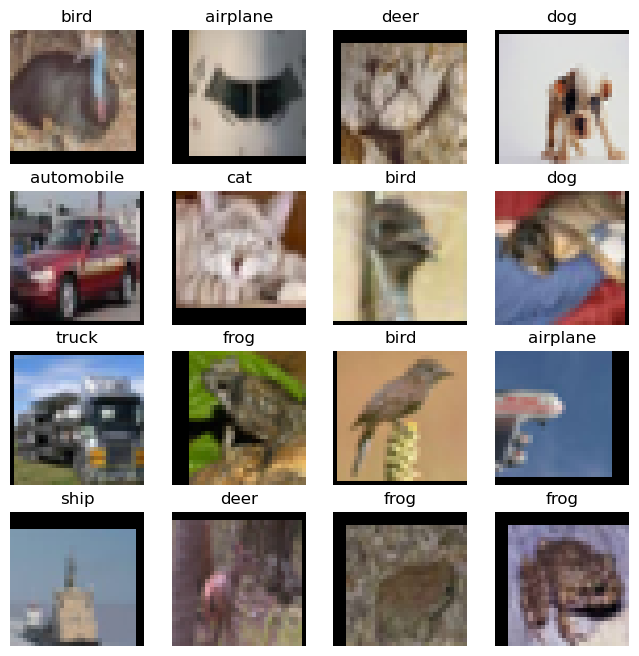

In [28]:
plot_random_samples(train_dataset)

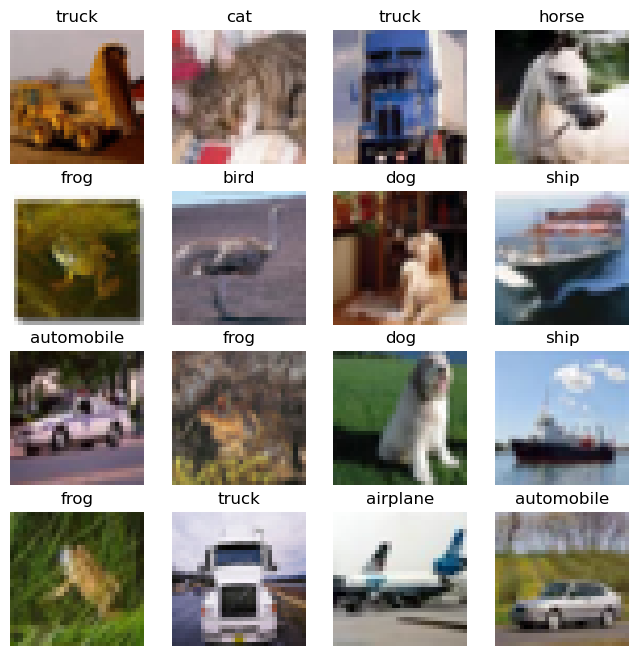

In [6]:
plot_random_samples(test_dataset)

Files already downloaded and verified


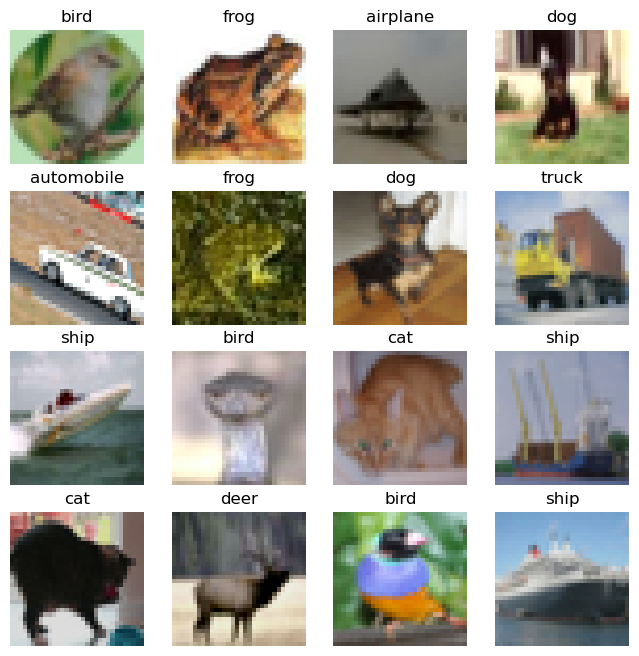

In [41]:
color_jitter_transform = transforms.Compose([
  transforms.ColorJitter(brightness=0.2,
                         contrast=0.2,
                         saturation=0.2,
                         hue=0.05),
  transforms.ToTensor(),
  transforms.Normalize(mean, std, inplace=True)
])

color_jitter_dataset = datasets.CIFAR10(root="data",
                                        download=True,
                                        train=True,
                                        transform=color_jitter_transform)

plot_random_samples(color_jitter_dataset)

# 3. Training and Evaluation Functions

In [7]:
def to_device(*args, device=device):
  return [arg.to(device, non_blocking=True) for arg in args]

def train_epoch(dataloader, model, criterion, optimizer, accuracy):
  model.train()

  train_loss, train_acc = 0, 0

  for X, y in tqdm(dataloader, desc="Training", leave=False):
    X, y = to_device(X, y)

    logits = model(X)

    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      train_loss += loss.cpu().item()
      train_acc += accuracy(preds, y).cpu().item()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def validate_epoch(dataloader, model, criterion, accuracy):
  model.eval()

  val_loss, val_acc = 0, 0

  with torch.no_grad():
    for X, y in tqdm(dataloader, desc="Validate", leave=False):
      X, y = to_device(X, y)

      logits = model(X)
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      loss = criterion(logits, y)

      val_loss += loss.cpu().item()
      val_acc += accuracy(preds, y).cpu().item()

  val_loss /= len(dataloader)
  val_acc /= len(dataloader)

  return val_loss, val_acc

In [8]:
def train(n_epochs,
          train_dataloader,
          test_dataloader,
          model,
          criterion,
          optimizer,
          scheduler,
          accuracy):

  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  for epoch in tqdm(range(1, n_epochs + 1), desc="Epoch", leave=False):
    train_loss, train_acc = train_epoch(train_dataloader, model, criterion, optimizer, accuracy)
    val_loss, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

    if scheduler is not None:
      scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch: {epoch: 4d} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .5f} | Val loss: {val_loss: .5f} | Val acc: {val_acc: .5f}")

  return train_losses, train_accs, val_losses, val_accs

In [9]:
def plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs):
  epochs = np.arange(1, n_epochs + 1)

  plt.figure(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="train loss")
  plt.plot(epochs, val_losses, label="val loss")
  plt.title("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accs, label="train acc")
  plt.plot(epochs, val_accs, label="val acc")
  plt.title("Acc")
  plt.legend()

# 4. Model Experiments and Architecture Tuning

논문의 실험을 CIFAR-10 데이터셋에 대해 재현하고자 했으며, 데이터셋의 특성에 맞게 논문에서 제시된 모델 구조를 축소하여 사용했다. 원래 모델은 입력 크기가 `(C, H, W) = (3, 224, 224)`였던 반면, CIFAR-10은 `(3, 32, 32)`로 약 7배 작다. 이에 따라 VGG 블록의 채널 수도 원본 대비 약 8분의 1 수준으로 축소하여 실험을 진행했다.

In [21]:
class VGGBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_convs, kernel_sizes=3):
    super().__init__()
    
    assert isinstance(kernel_sizes, int) or len(kernel_sizes) == n_convs
    
    if isinstance(kernel_sizes, int):
      kernel_sizes = [kernel_sizes for _ in range(n_convs)]
        
    paddings = [(kernel_size - 1) // 2 for kernel_size in kernel_sizes]
    
    layers = []

    for kernel_size, padding in zip(kernel_sizes, paddings):
      assert 2 * padding - kernel_size + 1 == 0

      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))

      in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

In [11]:
class TinyVGG_A(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=1),
      VGGBlock(8, 16, n_convs=1),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Epoch:    1 | Train loss:  1.87288 | Train acc:  0.27685 | Val loss:  1.63392 | Val acc:  0.40555


Epoch:    2 | Train loss:  1.62803 | Train acc:  0.38684 | Val loss:  1.37840 | Val acc:  0.47324


Epoch:    3 | Train loss:  1.49278 | Train acc:  0.45477 | Val loss:  1.31177 | Val acc:  0.53984


Epoch:    4 | Train loss:  1.39575 | Train acc:  0.50576 | Val loss:  1.23341 | Val acc:  0.56450


Epoch:    5 | Train loss:  1.32701 | Train acc:  0.53779 | Val loss:  1.13902 | Val acc:  0.58756


Epoch:    6 | Train loss:  1.26947 | Train acc:  0.56384 | Val loss:  1.24351 | Val acc:  0.57258


Epoch:    7 | Train loss:  1.22395 | Train acc:  0.58481 | Val loss:  1.06059 | Val acc:  0.62390


Epoch:    8 | Train loss:  1.19515 | Train acc:  0.59759 | Val loss:  1.01248 | Val acc:  0.63978


Epoch:    9 | Train loss:  1.15239 | Train acc:  0.61416 | Val loss:  0.97260 | Val acc:  0.65795


Epoch:   10 | Train loss:  1.12645 | Train acc:  0.62736 | Val loss:  0.98452 | Val acc:  0.66354


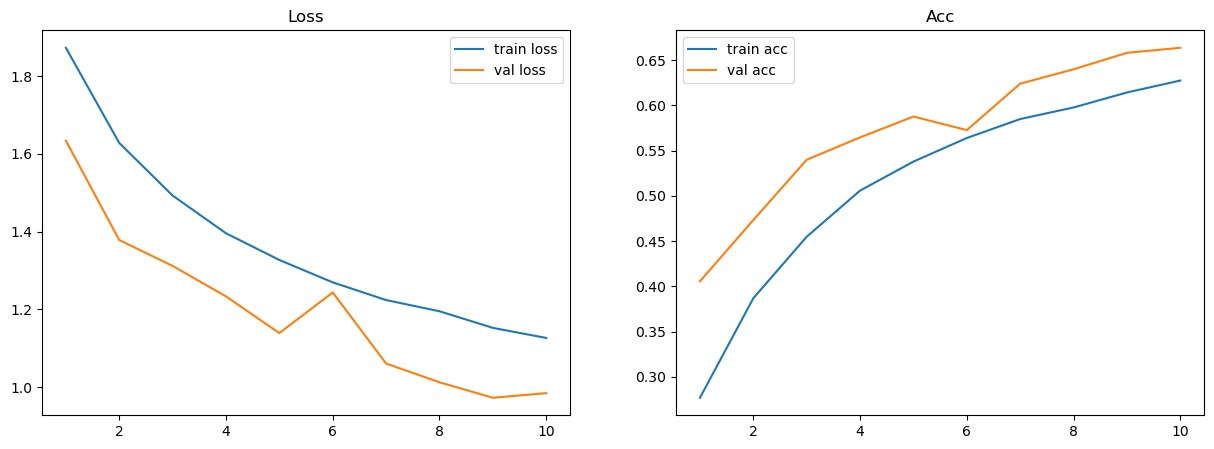

In [12]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

model = TinyVGG_A().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

## TinyVGG_A

In [13]:
class TinyVGG_A(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=1),
      VGGBlock(8, 16, n_convs=1),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out
  
TinyVGG_A()

TinyVGG_A(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): VGGBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): 

## TinyVGG_B

In [14]:
class TinyVGG_B(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out
  
TinyVGG_B()

TinyVGG_B(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stat

## TinyVGG_C

In [15]:
class TinyVGG_C(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(32, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(64, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out
  
TinyVGG_C()

TinyVGG_C(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stat

## TinyVGG_D

In [16]:
class TinyVGG_D(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3),
      VGGBlock(32, 64, n_convs=3),
      VGGBlock(64, 64, n_convs=3),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out
  
TinyVGG_D()

TinyVGG_D(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stat

## TinyVGG_E

In [17]:
class TinyVGG_E(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=4),
      VGGBlock(32, 64, n_convs=4),
      VGGBlock(64, 64, n_convs=4),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out
  
TinyVGG_E()

TinyVGG_E(
  (features): Sequential(
    (0): VGGBlock(
      (block): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stat